In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from torchvision import transforms
from models import encoder_AL, regressor_AL, load_ERM_FC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [35]:
class VADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: Directory containing subfolders with images and json files (e.g., 001 to 025)
        transform: Image transformations
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # To store image paths and corresponding valence-arousal data

        # Loop over subfolders (001 to 025)
        for folder_name in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, folder_name)
            print(f"Processing folder: {folder_path}")
            if os.path.isdir(folder_path):
                json_path = os.path.join(folder_path, f'{folder_name}.json')
                
                # Kiểm tra nếu tệp JSON tồn tại
                if not os.path.exists(json_path):
                    print(f"Tệp JSON không tồn tại: {json_path}")
                    continue
                
                print(f"Loading JSON file: {json_path}")
                with open(json_path, 'r') as f:
                    try:
                        annotations = json.load(f)
                    except json.JSONDecodeError:
                        print(f"Lỗi khi tải JSON: {json_path}")
                        continue

                # Lấy các mục frame từ JSON
                frames = annotations.get('frames', {})
                if not frames:
                    print(f"No frame data found in JSON: {json_path}")
                    continue
                
                # Lấy đường dẫn tệp ảnh và chú thích valence-arousal từ 'frames'
                for image_name in frames:
                    # Xử lý tệp ảnh với các phần mở rộng phổ biến như .png và .jpg
                    image_path_png = os.path.join(folder_path, f"{image_name}.png")
                    # image_path_jpg = os.path.join(folder_path, f"{image_name}.jpg")

                    if os.path.exists(image_path_png):
                        image_path = image_path_png
                    else:
                        print(f"Tệp ảnh không tồn tại: {image_name} trong {folder_path}")
                        continue
                    
                    # Load image and append to dataset
                    try:
                        with Image.open(image_path) as img:
                            img = img.convert('RGB')  # Chuyển đổi sang RGB nếu cần
                            valence_arousal = frames[image_name]
                            self.data.append((img, valence_arousal))
                    except Exception as e:
                        print(f"Lỗi khi mở ảnh: {image_path}, {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, valence_arousal = self.data[idx]
        if self.transform:
            image = self.transform(image)
        
        # Extracting valence and arousal from the dictionary
        valence = valence_arousal.get('valence', 0.0)
        arousal = valence_arousal.get('arousal', 0.0)
        
        # Returning the image along with valence and arousal as a tensor
        return image, torch.tensor([valence, arousal], dtype=torch.float)

# Ví dụ cách sử dụng:
# dataset = VADataset(root_dir='data/01', transform=None)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [36]:
root_dir = 'data/01'

# Transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate the dataset class and store the data
full_dataset = VADataset(root_dir=root_dir, transform=transform)

# Split the dataset into training (70%), validation (15%), and test (15%) sets
train_size = int(0.7 * len(full_dataset))
valid_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

train_data, valid_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, valid_size, test_size])

Processing folder: data/01\001
Loading JSON file: data/01\001\001.json
Processing folder: data/01\002
Loading JSON file: data/01\002\002.json
Processing folder: data/01\003
Loading JSON file: data/01\003\003.json
Processing folder: data/01\004
Loading JSON file: data/01\004\004.json
Processing folder: data/01\005
Loading JSON file: data/01\005\005.json
Processing folder: data/01\006
Loading JSON file: data/01\006\006.json
Processing folder: data/01\007
Loading JSON file: data/01\007\007.json
Processing folder: data/01\008
Loading JSON file: data/01\008\008.json
Processing folder: data/01\009
Loading JSON file: data/01\009\009.json
Processing folder: data/01\010
Loading JSON file: data/01\010\010.json
Processing folder: data/01\011
Loading JSON file: data/01\011\011.json
Processing folder: data/01\012
Loading JSON file: data/01\012\012.json
Processing folder: data/01\013
Loading JSON file: data/01\013\013.json
Processing folder: data/01\014
Loading JSON file: data/01\014\014.json
Proces

In [40]:
# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model architecture (encoder, regressor, and header from the previous code)
encoder = encoder_AL()
regressor = regressor_AL(latent_dim=256)
header = load_ERM_FC(erm_input_dim=256, erm_output_dim=2)  # 2 outputs for Valence and Arousal

In [41]:
# Move models to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = encoder.to(device)
regressor = regressor.to(device)
header = header.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(regressor.parameters()) + list(header.parameters()), lr=1e-4)

In [44]:
# Training loop with validation and recording loss history
train_losses = []
valid_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    encoder.train()
    regressor.train()
    header.train()

    running_loss = 0.0
    for i, (inputs, valence_arousal) in enumerate(train_loader):
        inputs = inputs.to(device)
        valence, arousal = valence_arousal[:, 0], valence_arousal[:, 1]
        valence, arousal = valence.to(device), arousal.to(device)
        
        optimizer.zero_grad()

        # Forward pass through the full model
        features = encoder(inputs)
        reg_output = regressor(features)
        outputs = header(reg_output)

        # Compute loss
        valence_loss = criterion(outputs[:, 0], valence)
        arousal_loss = criterion(outputs[:, 1], arousal)
        loss = valence_loss + arousal_loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

    # Validation phase
    encoder.eval()
    regressor.eval()
    header.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, valence_arousal in valid_loader:
            inputs = inputs.to(device)
            valence, arousal = valence_arousal[:, 0], valence_arousal[:, 1]
            valence, arousal = valence.to(device), arousal.to(device)
            
            features = encoder(inputs)
            reg_output = regressor(features)
            outputs = header(reg_output)

            valence_loss = criterion(outputs[:, 0], valence)
            arousal_loss = criterion(outputs[:, 1], arousal)
            loss = valence_loss + arousal_loss

            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    print(f'Validation Loss: {avg_valid_loss:.4f}')

Epoch [1/10], Train Loss: 1.2837
Validation Loss: 1.6735
Epoch [2/10], Train Loss: 1.2355
Validation Loss: 1.6206
Epoch [3/10], Train Loss: 1.2808
Validation Loss: 1.2995
Epoch [4/10], Train Loss: 1.1049
Validation Loss: 1.3021
Epoch [5/10], Train Loss: 1.0967
Validation Loss: 1.3403
Epoch [6/10], Train Loss: 1.2972
Validation Loss: 1.4104
Epoch [7/10], Train Loss: 1.1616
Validation Loss: 1.2046
Epoch [8/10], Train Loss: 1.1195
Validation Loss: 1.1433
Epoch [9/10], Train Loss: 1.2221
Validation Loss: 1.0175
Epoch [10/10], Train Loss: 1.0793
Validation Loss: 1.3353


In [45]:
# Test the model
encoder.eval()
regressor.eval()
header.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, valence_arousal in test_loader:
        inputs = inputs.to(device)
        valence, arousal = valence_arousal[:, 0], valence_arousal[:, 1]
        valence, arousal = valence.to(device), arousal.to(device)
        
        features = encoder(inputs)
        reg_output = regressor(features)
        outputs = header(reg_output)

        valence_loss = criterion(outputs[:, 0], valence)
        arousal_loss = criterion(outputs[:, 1], arousal)
        loss = valence_loss + arousal_loss

        test_loss += loss.item()
print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Test Loss: 1.2994


In [46]:
# Save the final model
torch.save(encoder.state_dict(), 'models/final_encoder.pth')
torch.save(regressor.state_dict(), 'models/final_regressor.pth')
torch.save(header.state_dict(), 'models/final_header.pth')

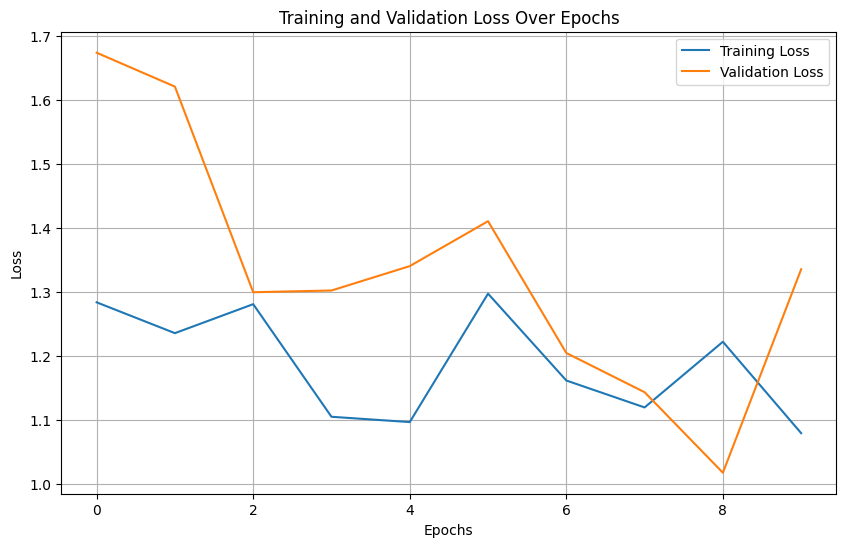

In [47]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()